In [1]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# For loading and transforming data
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

# Additional utilities
from torch.optim import Adam
from torch.nn import Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d
from torchvision.utils import save_image

In [2]:
import os
import shutil

# Base directory where the original folders are located
base_dir = '/kaggle/input/cv-project-detector/Classifier Data'

# New directory where the combined images will be located
new_base_dir = '/kaggle/working/images/'

# Create new directories if they don't exist
os.makedirs(os.path.join(new_base_dir, 'Diseased'), exist_ok=True)
os.makedirs(os.path.join(new_base_dir, 'No_Disease'), exist_ok=True)

# Categories and diseases
categories = ['train', 'val']
diseases = ['Disease_Present', 'No_Disease']

# Copy the files
for cat in categories:
    for disease in diseases:
        # Directory where the current images are located
        old_dir = os.path.join(base_dir, cat, disease)
        
        # Directory where the images are going to be moved to
        new_dir_name = 'Diseased' if disease == 'Disease_Present' else 'No_Disease'
        new_dir = os.path.join(new_base_dir, new_dir_name)

        # Copy each file
        for filename in os.listdir(old_dir):
            old_file = os.path.join(old_dir, filename)
            new_file = os.path.join(new_dir, filename)
            
            # Check if the file already exists, if so, skip or rename
            if not os.path.exists(new_file):
                shutil.copy(old_file, new_file)  # Copy the file
            else:
                # If a file with the same name exists, append an extra identifier before the extension
                base, extension = os.path.splitext(new_file)
                new_filename = base + '_duplicate' + extension
                shutil.copy(old_file, new_filename)


In [3]:
import torch

class Generator(nn.Module):
    def __init__(self, z_dim, img_shape, n_classes):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim + n_classes, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, self.img_shape[0], 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Embed labels and concatenate with the noise vector
        label_emb = self.label_embedding(labels)  # Transform labels into embeddings
        label_emb = label_emb.unsqueeze(2).unsqueeze(3)  # Reshape to match the batch and noise dimensions
        z = z.unsqueeze(2).unsqueeze(3)  # Reshape z to match the batch and label dimensions

        # Concatenate noise vector z and label embeddings along the channel dimension
        input_gen = torch.cat([z, label_emb], dim=1)

        # Generate an image from the noise vector and labels
        output = self.model(input_gen)
        output = output.view(-1, *self.img_shape)  # Reshape to the output image size (C, H, W)

        return output


In [4]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_shape, n_classes):
        super(Discriminator, self).__init__()
        nc = img_shape[0]  # Number of channels in the images

        self.label_embedding = nn.Embedding(n_classes, n_classes)
        self.model = nn.Sequential(
            nn.Conv2d(nc + n_classes, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 2048, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2048, 1, 4, stride=1, padding=0, bias=False),
            nn.Flatten()
        )

    def forward(self, img, labels):
        label_embedding = self.label_embedding(labels)
        label_embedding = label_embedding.view(-1, label_embedding.size(1), 1, 1)
        label_embedding = label_embedding.repeat(1, 1, img.shape[2], img.shape[3])
        img = torch.cat((img, label_embedding), 1)

        return self.model(img)


In [12]:
import torch.optim as optim

# Hyperparameters
z_dim = 100
img_size = 256
img_channels = 3  # RGB images
n_classes = 2  # Diseased or not
lr_d = 2e-6  # Lower learning rate for better stability
lr_g = 2e-4
batch_size = 32
epochs = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize generator and discriminator
img_shape = (img_channels, img_size, img_size)
generator = Generator(z_dim=z_dim, img_shape=img_shape, n_classes=n_classes).to(device)
discriminator = Discriminator(img_shape=img_shape, n_classes=n_classes).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.0, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.0, 0.9))


In [13]:
# Image transformations
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Data loaders for your dataset
dataloader = DataLoader(
    datasets.ImageFolder('/kaggle/working/images/', transform=transform),
    batch_size=batch_size,
    shuffle=True,
)


[Epoch 0/100] [D loss: -10.063674474196] [G loss: -1.7482693239074687]


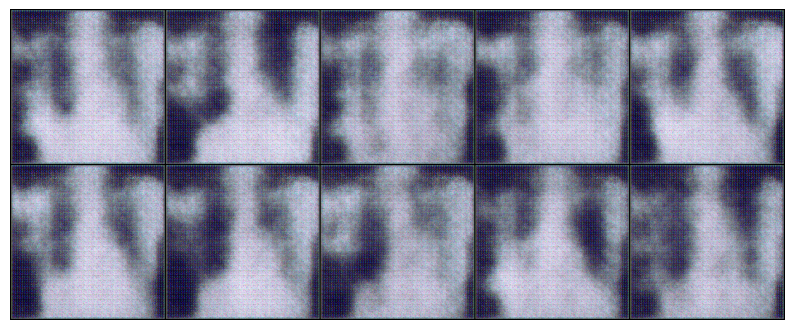

[Epoch 1/100] [D loss: -2.9562422861294313] [G loss: -0.6549818979009338]
[Epoch 2/100] [D loss: 0.7154492793299935] [G loss: -2.1314890216226163]
[Epoch 3/100] [D loss: 0.40692773537202315] [G loss: -2.549443910303323]
[Epoch 4/100] [D loss: 0.3069874692234126] [G loss: -2.664386986390404]
[Epoch 5/100] [D loss: 0.34737456489693036] [G loss: -2.5564419199591097]
[Epoch 6/100] [D loss: 0.5284454701163552] [G loss: -2.364193951306136]
[Epoch 7/100] [D loss: 0.8463793524286963] [G loss: -2.1128308785998304]
[Epoch 8/100] [D loss: 1.113590213060379] [G loss: -2.233105656893357]
[Epoch 9/100] [D loss: 1.0934772348403932] [G loss: -2.5016102674214737]
[Epoch 10/100] [D loss: 0.9524654986099763] [G loss: -3.1389341548733087]


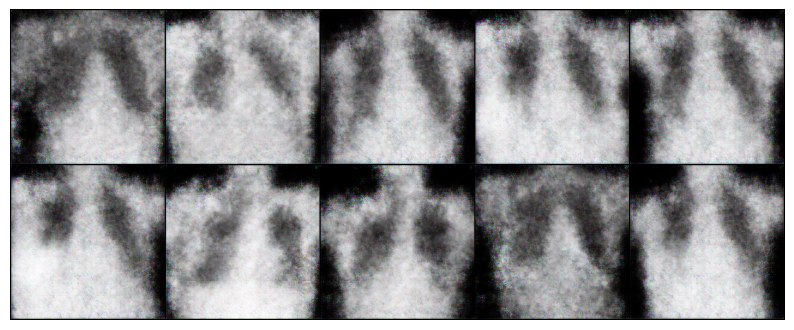

[Epoch 11/100] [D loss: 0.8416791797767986] [G loss: -3.325317901113759]
[Epoch 12/100] [D loss: 0.7498821658979763] [G loss: -3.7011297967122947]
[Epoch 13/100] [D loss: 0.7577682529254394] [G loss: -3.9098796948142676]
[Epoch 14/100] [D loss: 0.6444975475018675] [G loss: -4.851608926835268]
[Epoch 15/100] [D loss: 0.6809185621413317] [G loss: -5.259078989858213]
[Epoch 16/100] [D loss: 0.7119471610676159] [G loss: -5.060751808726269]
[Epoch 17/100] [D loss: 0.6713459073955362] [G loss: -4.973518493382827]
[Epoch 18/100] [D loss: 0.6430348571051251] [G loss: -4.4652553433957305]
[Epoch 19/100] [D loss: 0.5804974987561052] [G loss: -4.574318465979203]
[Epoch 20/100] [D loss: 0.5227904814210805] [G loss: -3.859034343906071]


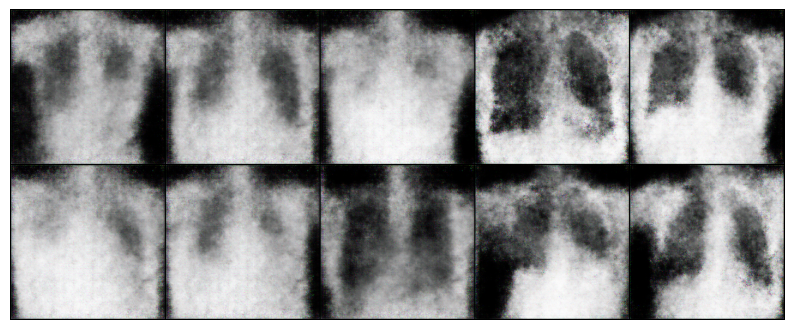

[Epoch 21/100] [D loss: 0.5180299554629759] [G loss: -5.082227144552314]
[Epoch 22/100] [D loss: 0.4343444545973431] [G loss: -6.090757178223652]
[Epoch 23/100] [D loss: 0.4318603428114544] [G loss: -6.899093889671823]
[Epoch 24/100] [D loss: 0.5387149268659679] [G loss: -6.645346988802371]
[Epoch 25/100] [D loss: 0.47685039933432233] [G loss: -6.27608952574108]
[Epoch 26/100] [D loss: 0.553837374042381] [G loss: -6.010465580484142]
[Epoch 27/100] [D loss: 0.44888969654386696] [G loss: -5.721257541490638]
[Epoch 28/100] [D loss: 0.4394193092801354] [G loss: -5.894422238287718]
[Epoch 29/100] [D loss: 0.3822791599143635] [G loss: -6.029321102992348]
[Epoch 30/100] [D loss: 0.37871910291639244] [G loss: -6.31654123119686]


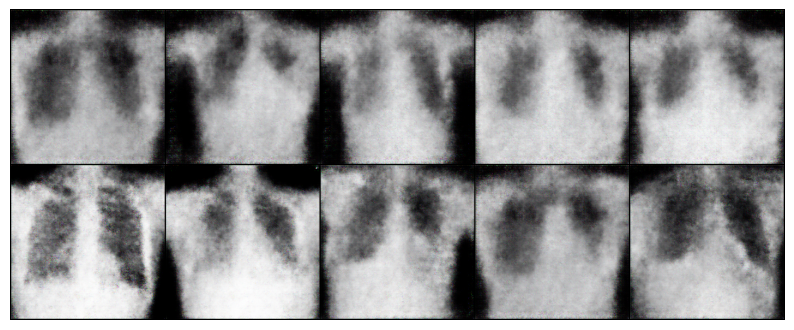

[Epoch 31/100] [D loss: 0.44193393539298664] [G loss: -6.067344522994498]
[Epoch 32/100] [D loss: 0.3883571783250028] [G loss: -5.936727272427601]
[Epoch 33/100] [D loss: 0.4329486427794803] [G loss: -4.97984200456868]
[Epoch 34/100] [D loss: 0.30194100740281016] [G loss: -5.089476473953413]
[Epoch 35/100] [D loss: 0.25190052539110186] [G loss: -6.366457604843637]
[Epoch 36/100] [D loss: 0.4064582103355364] [G loss: -6.454280796258346]
[Epoch 37/100] [D loss: 0.29427725850181147] [G loss: -6.223329367844955]
[Epoch 38/100] [D loss: 0.3264524539492347] [G loss: -6.6082005448963335]
[Epoch 39/100] [D loss: 0.2992059344595129] [G loss: -6.537364638370017]
[Epoch 40/100] [D loss: 0.26819185968149795] [G loss: -6.2591675208962485]


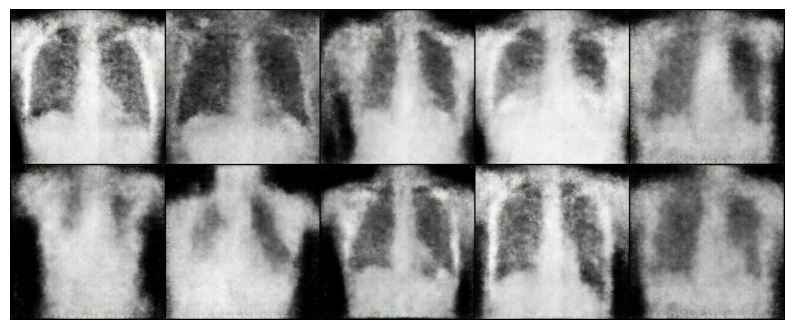

[Epoch 41/100] [D loss: 0.4248600718785416] [G loss: -5.750888606776362]
[Epoch 42/100] [D loss: 0.30764815334569323] [G loss: -5.598672265591829]
[Epoch 43/100] [D loss: 0.25307574538344685] [G loss: -4.449756285418635]
[Epoch 44/100] [D loss: 0.24514526082710786] [G loss: -5.015411470247352]
[Epoch 45/100] [D loss: 0.1727544512125579] [G loss: -4.7404428642729055]
[Epoch 46/100] [D loss: 0.2788805590705438] [G loss: -5.720381355803946]
[Epoch 47/100] [D loss: 0.27616198616948995] [G loss: -4.910512434399647]
[Epoch 48/100] [D loss: 0.293834058181806] [G loss: -5.258043911146081]
[Epoch 49/100] [D loss: 0.24507404119453646] [G loss: -5.141642420188241]
[Epoch 50/100] [D loss: 0.22231221427971667] [G loss: -4.359569347423056]


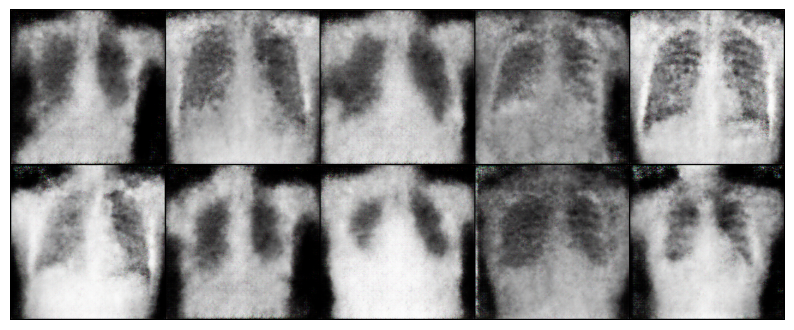

[Epoch 51/100] [D loss: 0.2095881720700047] [G loss: -4.117385358914085]
[Epoch 52/100] [D loss: 0.24256209767677567] [G loss: -5.01889315377111]
[Epoch 53/100] [D loss: 0.24243069140748544] [G loss: -4.976964919463448]
[Epoch 54/100] [D loss: 0.20505123165520756] [G loss: -4.289353184078051]
[Epoch 55/100] [D loss: 0.10750889699567448] [G loss: -5.62525477875834]
[Epoch 56/100] [D loss: 0.24469592572613197] [G loss: -6.740287521611089]
[Epoch 57/100] [D loss: 0.036718863783912224] [G loss: -5.408709808536198]
[Epoch 58/100] [D loss: 0.11867749731649052] [G loss: -6.066146990527278]
[Epoch 59/100] [D loss: 0.26314658426425674] [G loss: -7.115280182465263]
[Epoch 60/100] [D loss: 0.2543224915184758] [G loss: -5.779626193253891]


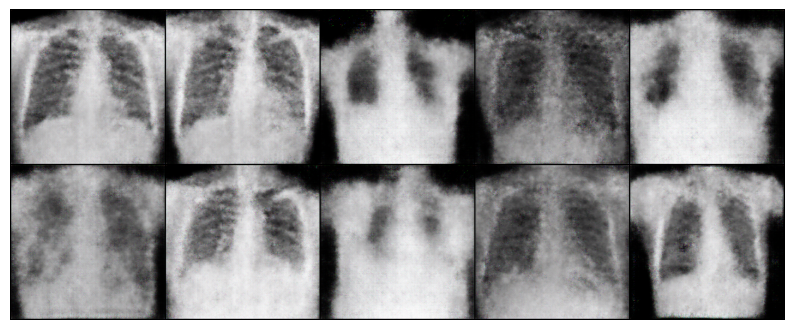

[Epoch 61/100] [D loss: 0.18672591026533733] [G loss: -5.521457457024118]
[Epoch 62/100] [D loss: 0.21368243660439146] [G loss: -5.336642241996268]
[Epoch 63/100] [D loss: 0.21424239073287357] [G loss: -5.637507679669754]
[Epoch 64/100] [D loss: 0.19949017722498286] [G loss: -5.849690582441247]
[Epoch 65/100] [D loss: 0.1483039490607652] [G loss: -5.274457065955453]
[Epoch 66/100] [D loss: 0.20697570002214474] [G loss: -4.6024982488673665]
[Epoch 67/100] [D loss: 0.15557568061080845] [G loss: -4.62279286591903]
[Epoch 68/100] [D loss: 0.0806047420474616] [G loss: -5.362107204354328]
[Epoch 69/100] [D loss: 0.10218599873510274] [G loss: -6.575435317080954]
[Epoch 70/100] [D loss: 0.16724067878994076] [G loss: -6.577378936435865]


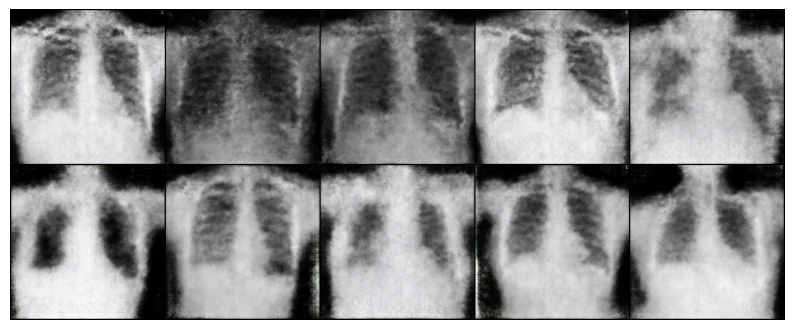

[Epoch 71/100] [D loss: 0.16105843254788355] [G loss: -4.984259395495705]
[Epoch 72/100] [D loss: 0.1215074983374639] [G loss: -4.343416302100472]
[Epoch 73/100] [D loss: 0.1265658936310898] [G loss: -5.004923107831375]
[Epoch 74/100] [D loss: 0.12974999364804138] [G loss: -6.003751482652581]
[Epoch 75/100] [D loss: 0.11253086339343678] [G loss: -4.864014060600944]
[Epoch 76/100] [D loss: 0.12603374074805868] [G loss: -5.254164361435434]
[Epoch 77/100] [D loss: 0.1557921531999653] [G loss: -4.867150837960451]
[Epoch 78/100] [D loss: 0.08720201436091553] [G loss: -4.890964007895926]
[Epoch 79/100] [D loss: 0.12316509905186566] [G loss: -5.028508670952009]
[Epoch 80/100] [D loss: 0.049537340944463555] [G loss: -5.315001358156619]


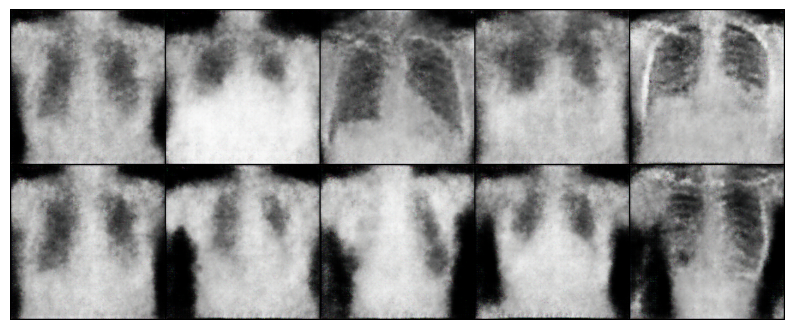

[Epoch 81/100] [D loss: 0.12635583987290208] [G loss: -5.49848152761874]
[Epoch 82/100] [D loss: 0.11081262241032991] [G loss: -4.341142682925515]
[Epoch 83/100] [D loss: 0.09745172730901025] [G loss: -5.2064531704653865]
[Epoch 84/100] [D loss: 0.06651874299753796] [G loss: -3.773005011289016]
[Epoch 85/100] [D loss: 0.07962935440919616] [G loss: -4.51971604772236]
[Epoch 86/100] [D loss: 0.07457434918392788] [G loss: -5.658632884854856]
[Epoch 87/100] [D loss: 0.03968735738234087] [G loss: -5.847999518332274]
[Epoch 88/100] [D loss: 0.1298274218020114] [G loss: -5.842989201131075]
[Epoch 89/100] [D loss: 0.02119756273247979] [G loss: -6.026479132797407]
[Epoch 90/100] [D loss: 0.11767137267372825] [G loss: -5.730040254800216]


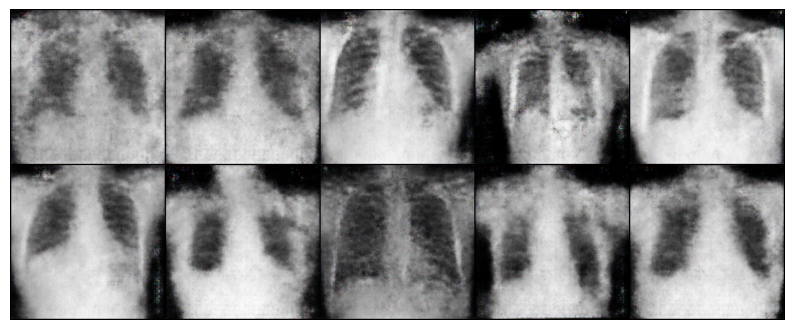

[Epoch 91/100] [D loss: 0.08502935316752304] [G loss: -4.669252224590467]
[Epoch 92/100] [D loss: 0.08045045630498365] [G loss: -4.6303780752679575]
[Epoch 93/100] [D loss: 0.038248197707262906] [G loss: -4.650745101596998]
[Epoch 94/100] [D loss: -0.002941723018884659] [G loss: -5.124202349911565]
[Epoch 95/100] [D loss: 0.0016956271908499978] [G loss: -5.764099533143251]
[Epoch 96/100] [D loss: 0.05407463798468763] [G loss: -6.085660133672797]
[Epoch 97/100] [D loss: 0.10732471203939481] [G loss: -5.6091227790583735]
[Epoch 98/100] [D loss: 0.058495468565008854] [G loss: -6.039917588233948]
[Epoch 99/100] [D loss: -0.06622620178894563] [G loss: -5.81625142045643]


In [14]:
import torch
import os
import numpy as np
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Assume the setup for generator, discriminator, dataloader, and optimizer_D, optimizer_G are defined
# as well as variables like device, z_dim, n_classes, etc.

# Define a directory to save model checkpoints and generated images
checkpoint_dir = '/kaggle/working/checkpoints_wgans/'
os.makedirs(checkpoint_dir, exist_ok=True)
generated_images_dir = '/kaggle/working/generated_images_wgans/'
os.makedirs(generated_images_dir, exist_ok=True)

def show_and_save_generated(imgs, labels, epoch, generated_images_dir, num_images=10):
    imgs = (imgs + 1) / 2  # Rescale images from [-1,1] to [0,1]
    grid = make_grid(imgs[:num_images], nrow=5).detach().cpu().numpy()
    grid = np.transpose(grid, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

    for i, img in enumerate(imgs.cpu()):  # Move tensors to CPU before converting
        img = Image.fromarray((img.numpy() * 255).astype('uint8'), mode='RGB')
        class_label = 'Disease' if labels[i].item() == 0 else 'No_Diseased'
        class_dir = os.path.join(generated_images_dir, class_label)
        os.makedirs(class_dir, exist_ok=True)
        image_path = os.path.join(class_dir, f'epoch_{epoch}_image_{i}.png')
        img.save(image_path)


def compute_gradient_penalty(D, real_samples, fake_samples, labels):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    alpha = alpha.expand_as(real_samples)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    grad_outputs = torch.ones_like(d_interpolates, device=real_samples.device)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=grad_outputs, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

epoch_losses = {'generator': [], 'discriminator': []}
critic_iterations = 3
lambda_gp = 8

for epoch in range(epochs):
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Training Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(imgs.size(0), z_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)
        fake_imgs = generator(z, gen_labels)
        real_validity = discriminator(real_imgs, labels)
        fake_validity = discriminator(fake_imgs.detach(), gen_labels)
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs, fake_imgs, labels)
        d_loss = fake_validity.mean() - real_validity.mean() + lambda_gp * gradient_penalty
        d_loss.backward()
        optimizer_D.step()
        epoch_d_loss += d_loss.item()

        # Training Generator
        if i % critic_iterations == 0:
            optimizer_G.zero_grad()
            gen_imgs = generator(z, gen_labels)
            g_loss = -discriminator(gen_imgs, gen_labels).mean()
            g_loss.backward()
            optimizer_G.step()
            epoch_g_loss += g_loss.item()

    # Average losses for the epoch
    epoch_losses['generator'].append(epoch_g_loss / (len(dataloader) // critic_iterations + 1))
    epoch_losses['discriminator'].append(epoch_d_loss / len(dataloader))

    # Output training stats
    print(f"[Epoch {epoch}/{epochs}] [D loss: {epoch_d_loss / len(dataloader)}] [G loss: {epoch_g_loss / (len(dataloader) // critic_iterations + 1)}]")

    if epoch % 10 == 0:
        torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f'generator_epoch_{epoch}.pth'))
        torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f'discriminator_epoch_{epoch}.pth'))
        with torch.no_grad():
            z_example = torch.randn(10, z_dim).to(device)
            gen_labels_example = torch.randint(0, n_classes, (10,)).to(device)
            gen_imgs_example = generator(z_example, gen_labels_example)
            show_and_save_generated(gen_imgs_example, gen_labels_example, epoch, generated_images_dir, num_images=10)

# Plotly for loss visualization
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(epochs)), y=epoch_losses['generator'], mode='lines+markers', name='Generator Loss'))
fig.add_trace(go.Scatter(x=list(range(epochs)), y=epoch_losses['discriminator'], mode='lines+markers', name='Discriminator Loss'))
fig.update_layout(title='Training Losses', xaxis_title='Epoch', yaxis_title='Loss', legend_title='Component')
fig.show()
